# Kaggle ML Competiton Entry

## Titanic Survivability Prediction

----

April 2022

# 0. Configure environment

## 0.1 Import libraries

In [26]:
# Data handling
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Feature selection
from sklearn.feature_selection import RFE

# Visualization
from sklearn.tree import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt

# Environment setup
%matplotlib inline
pd.set_option('display.max_columns', None)

## 0.2 Set data path

In [2]:
data_path = "/".join(os.getcwd().split("/")[:-1]) + "/data/raw/"

## 0.3 Load data

In [63]:
titanic = pd.read_csv(f"{data_path}train.csv")

In [83]:
# VALIDATION SET
titanic = pd.read_csv(f"{data_path}test.csv")

# 1. Data Exploration

----

## 1.1 Data fields

`PassengerId` > Passenger ID

`Survived` > 1 if the passenger survived, 0 if they did not

`Pclass` > Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)

`Name` > Name of passenger

`Sex` > Sex of passenger

`Age` > Age of passenger

`SibSp` > Number of siblings / spouses aboard the Titanic

`Parch` > Number of parents / children aboard the Titanic

`Ticket` > Ticket Number

`Fare` > Passenger fare

`Cabin` > Cabin number

`Embarked` > Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)


## 1.2 Variable exploration

In [5]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 2. Data preparation

----

## 2.1 Drop unused columns

In [84]:
titanic = titanic.drop(columns = ["Name", "Ticket"])

## 2.2 NaN value handling

In [85]:
# Cabin column
titanic['Cabin'] = titanic['Cabin'].fillna("NONE")

In [86]:
# Age column -- fill all NA values with the average age of all passengers
titanic['Age'] = titanic['Age'].fillna(titanic["Age"].mean())

# 3. Feature engineering

----

## 3.1 Utility functions

In [87]:
def removeNumbers(string):
    return (''.join([i for i in string if not i.isdigit()]))[0]

## 3.2 Dummy variables

Given the nature and makeup of the data, we will next create dummy variables for:

- Pclass
- Sex
- Cabin (specifically the level)
- Embarked

In [88]:
# PCLASS
pclass_df = pd.get_dummies(titanic['Pclass'], drop_first=False, dummy_na=True)
pclass_df.columns = ['FirstClass', 'SecondClass', 'ThirdClass', 'NoClass']
titanic = pd.concat([titanic, pclass_df], axis=1)

In [89]:
# SEX
sex_df = pd.get_dummies(titanic['Sex'], drop_first=False, dummy_na=True)
sex_df.columns = ['Female', 'Male', 'UnknownSex']
titanic = pd.concat([titanic, sex_df], axis=1)

In [90]:
# CABIN
titanic['Cabin'] = titanic['Cabin'].apply(removeNumbers)
cabin_df = pd.get_dummies(titanic['Cabin'], drop_first=False, dummy_na=True)
#cabin_df.columns = ['CabinA', 'CabinB', 'CabinC', 'CabinD', 'CabinE', 'CabinF', 'CabinG', 'CabinN', 'CabinT', 'NoCabin']
titanic = pd.concat([titanic, cabin_df], axis=1)

In [91]:
# Embarked
embarked_df = pd.get_dummies(titanic['Embarked'], drop_first=False, dummy_na=True)
embarked_df.columns = ['EmbarkedC', 'EmbarkedQ', 'EmbarkedS', 'EmbarkedNA']
titanic = pd.concat([titanic, embarked_df], axis=1)

In [92]:
# Get total number of contacts on boat
titanic['NumContacts'] = titanic['Parch'] + titanic['SibSp']

In [93]:
# Drop orignal columns
ids = titanic['PassengerId']
titanic = titanic.drop(columns = ['PassengerId', 'Pclass', 'Sex', 'Cabin', 'Embarked', 'Parch', 'SibSp'])

# 4. Modeling

----

In [95]:
titanic

,Age,Fare,FirstClass,SecondClass,ThirdClass,NoClass,Female,Male,UnknownSex,A,B,C,D,E,F,G,N,NaN,EmbarkedC,EmbarkedQ,EmbarkedS,EmbarkedNA,NumContacts
0,34.50000,7.8292,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,47.00000,7.0000,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
2,62.00000,9.6875,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,27.00000,8.6625,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,22.00000,12.2875,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,30.27259,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
414,39.00000,108.9000,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
415,38.50000,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
416,30.27259,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [75]:
def rfe_selection(model, data):
    # Assign data-related variables
    features = ['Age', 'Fare', 'FirstClass', 'SecondClass', 'ThirdClass', 'NoClass', 'Female', 'Male', 'UnknownSex', 'CabinA', 'CabinB', 'CabinC', 'CabinD', 'CabinE', 'CabinF', 'CabinG', 'CabinN', 'CabinT', 'NoCabin', 'EmbarkedC', 'EmbarkedQ' , 'EmbarkedS', 'EmbarkedNA', 'NumContacts']
    df_vals = data.values

    # Identify the column names of the features
    inputs = df_vals[:,0:len(features)-1]
    response_variable = df_vals[:,len(features)-1]

    # Feature extraction
    #dt_classifier = DecisionTreeClassifier(max_depth = 5)
    rfe = RFE(model, step = 3)
    fit = rfe.fit(inputs, response_variable)

    # Create list with the target feature names
    selected_features = list(np.array(features[:-1])[np.array(fit.support_)])
    
    # Return a list containing the column names of the most relevant features
    return selected_features

In [76]:
# Create empty lists
depth_list = []
model_error = []

# Split data before evaluation for consistency in results
dt_x = titanic.drop(columns = ["Survived"]) #Use columns identified above
dt_y = titanic[["Survived"]]

dt_x_train, dt_x_test, dt_y_train, dt_y_test = train_test_split(dt_x, dt_y, test_size=0.2)

# Loop through each depth
for d in range(2,11):
    # Append the depth to the list
    depth_list.append(d)
    
    # Create model input lists
    dt_selected_features = rfe_selection(model = DecisionTreeClassifier(max_depth = d), data = titanic) #Find most relevant model inputs
    
    # Create and fit model
    dt_classifier = DecisionTreeClassifier(max_depth = d)
    dt_classifier = dt_classifier.fit(dt_x_train[titanic.columns.intersection(dt_selected_features)], dt_y_train)
    
    # Test model and log error
    dt_y_pred = dt_classifier.predict(dt_x_test[titanic.columns.intersection(dt_selected_features)])
    model_error.append(accuracy_score(dt_y_pred, dt_y_test))

Text(0, 0.5, 'Accuracy')

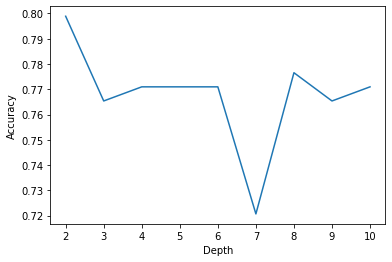

In [77]:
plt.plot(depth_list, model_error)
plt.xlabel("Depth")
plt.ylabel("Accuracy")

In [78]:
# Identify most-relevant model features
dt_selected_features = rfe_selection(model = DecisionTreeClassifier(max_depth = depth_list[model_error.index(max(model_error))]), data = titanic) #Find most relevant model inputs

# Split the data into x and y
dt_x = titanic[titanic.columns.intersection(dt_selected_features)] #Use columns identified above
dt_y = titanic[["Survived"]]

In [79]:
dt_selected_features

['Fare',
 'NoClass',
 'Female',
 'Male',
 'UnknownSex',
 'CabinC',
 'CabinD',
 'CabinE',
 'CabinF',
 'EmbarkedS',
 'EmbarkedNA']

In [80]:
# Create classifier with a depth equal to that of the lowest error
dt_classifier = DecisionTreeClassifier(max_depth = depth_list[model_error.index(max(model_error))])

# Fit the classifier with the training data
dt_classifier = dt_classifier.fit(dt_x_train, dt_y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [81]:
# Predict test data with classifier
dt_y_pred_test = dt_classifier.predict(dt_x_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [82]:
confusion_matrix(dt_y_test, dt_y_pred_test)

array([[106,   1],
       [ 37,  35]])

In [98]:
competition_predictions = dt_classifier.predict(titanic)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(


ValueError: X has 23 features, but DecisionTreeClassifier is expecting 24 features as input.

In [97]:
titanic['Fare'] = titanic['Fare'].fillna(0.0)

In [96]:
titanic.describe()

,Age,Fare,FirstClass,SecondClass,ThirdClass,NoClass,Female,Male,UnknownSex,A,B,C,D,E,F,G,N,NaN,EmbarkedC,EmbarkedQ,EmbarkedS,EmbarkedNA,NumContacts
count,418.000000,417.000000,418.000000,418.000000,418.000000,418.0,418.000000,418.000000,418.0,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.0,418.000000,418.000000,418.000000,418.0,418.000000
mean,30.272590,35.627188,0.255981,0.222488,0.521531,0.0,0.363636,0.636364,0.0,0.016746,0.043062,0.083732,0.031100,0.021531,0.019139,0.002392,0.782297,0.0,0.244019,0.110048,0.645933,0.0,0.839713
std,12.634534,55.907576,0.436934,0.416416,0.500135,0.0,0.481622,0.481622,0.0,0.128474,0.203240,0.277317,0.173797,0.145320,0.137177,0.048912,0.413179,0.0,0.430019,0.313324,0.478803,0.0,1.519072
min,0.170000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
25%,23.000000,7.895800,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
50%,30.272590,14.454200,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000
75%,35.750000,31.500000,1.000000,0.000000,1.000000,0.0,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.0,1.000000
max,76.000000,512.329200,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,10.000000
